In [1]:
import iris,glob,os
import numpy as np
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
try:
    from iris.util import equalise_attributes
except:pass
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import interp1d
import iris.coord_categorisation as icc
import sys
import xarray as xr
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.transforms as mtrans

from scipy.stats import spearmanr,pearsonr,kendalltau
from matplotlib.patches import Polygon

os.chdir('./')
from feedback_calc import *

In [2]:
modelnames = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5',
       'E3SM-1-0', 'FGOALS-f3-L', 'GFDL-ESM4', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1',
       'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1',
       'UKESM1-0-LL']

In [3]:

def retrieve_institution(modelnames):
    col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
    query = dict(
        experiment_id='piControl', # pick the `abrupt-4xCO2` and `piControl` forcing experiments
        table_id='Amon',
        variable_id='tas',  # choose to look at near-surface air temperature (tas) as our variable
        source_id=modelnames,
    )
    col_subset = col.search(require_all_on=["source_id"], **query)
    col_subset=col_subset.df.loc[col_subset.df['member_id'].str.contains("r1i1p1", case=False)]
    col_subset = col_subset.groupby('source_id').apply(lambda x: x.iloc[0])

    return col_subset['institution_id'],col_subset['member_id']


def FigS4():
    
    inst = retrieve_institution(modelnames)[0].values
    ms = np.zeros(np.shape(inst))
    for i in np.unique(inst):
        ms[inst==i] = range((inst==i).sum())
    
    toplot=np.load('./output/cmip_pi_feeds_binnedpi_full_mask_compare_Tfull.npy')
    toplot_4x=np.load('./output/cmip_4xco2_feeds_binned4x_full_mask_compare_Tfull.npy')
    ys_0=np.transpose(feedback_calc_B_obs(full=True,Tfull=True))
    
    from scipy.stats import spearmanr,pearsonr,kendalltau
    from matplotlib.patches import Polygon

    fig,axs=plt.subplots(ncols=2,nrows=2,figsize=[10,7.5])
    axs = np.ravel(axs)
    [sns.scatterplot(x=np.array(toplot)[i],y=np.array(toplot_4x)[i],ax=ax,s=30,hue=inst,style=ms,zorder=4) for ax,i in zip(axs,range(3))]

    for ax in axs[:-1]:
        handles,labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    [ax.set_title(t+'; r={0:.02f}, p={1:.03f}'.format(pearsonr(toplot[i],toplot_4x[i])[0],pearsonr(toplot[i],toplot_4x[i])[1]),loc='left') 
        for i,ax,t in zip(range(3),axs,['a) SW','b) LW','c) Net'])]
    [ax.grid() for ax in axs]
    [ax.axvline(y,linestyle='dashed',color='k') for ax,y in zip(axs,ys_0[0])]
    for ax,a,b in zip(axs,ys_0[0],ys_0[1]):
        rect=Polygon([[a-b,-10],[a-b,10],[a+b,10],[a+b,-10]],fc='0.5',alpha=0.3,ec=None)
        ax.add_patch(rect)
    
    for i,x0,dx in zip(range(3),ys_0[0],ys_0[1]):
        y0=lin_predict(toplot_4x[i],toplot[i],x0)
        y_ci=[lin_predict(toplot_4x[i],toplot[i],dx)]
        print(f'fit: {y0}, ci:{y_ci}')
        
    for x,y in zip(toplot,toplot_4x):
        print(lin_reg(y,x)['vals'])

    axs_xlim = [ax.get_xlim() for ax in axs]
    axs_ylim = [ax.get_ylim() for ax in axs]
    ps = [sns.regplot(x=toplot[i],y=toplot_4x[i],ax=ax,scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1}) for ax,i in zip(axs,range(3))]

    [ax.set_xlim(xlim) for ax,xlim in zip(axs,axs_xlim)]
    [ax.set_ylim(ylim) for ax,ylim in zip(axs,axs_ylim)]
    axs[-1].axis('off')

    [ax.set_xlabel(r'piControl (Wm$^{-2}$K$^{-1}$)',fontsize=12) for ax in axs[:-1]]
    [ax.set_ylabel(r'4xCO2-pic (Wm$^{-2}$K$^{-1}$)',fontsize=12) for ax in axs[:-1]]

    fig.legend(loc='center right',handles=handles[:-4],labels=labels[:-4])
    plt.tight_layout(rect=[0.05, 0, 0.78, 0.95])


fit: 0.4185637232136454, ci:[0.13587274487624096]
fit: 0.24548808684186785, ci:[0.5893568029594602]
fit: 0.49383244232304657, ci:[0.426753491686723]
(0.3959888940594912, -0.1957565250235544)
(0.3066027268879052, 0.4036738830941135)
(0.15250167271551293, 0.33592817724129015)


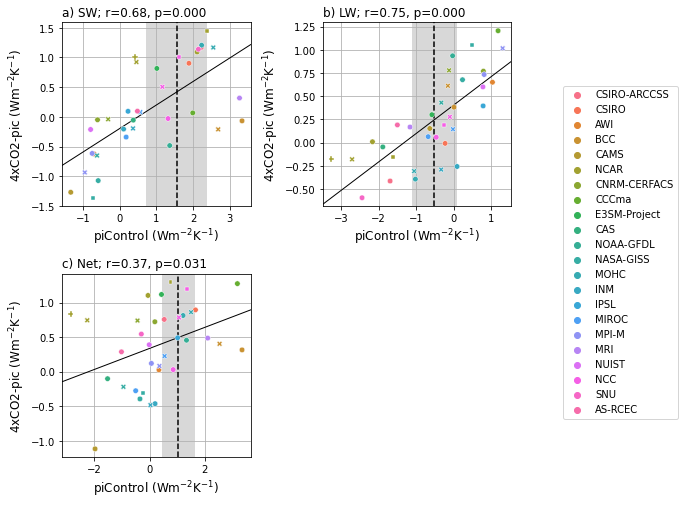

In [4]:
FigS4()
plt.savefig(f'./paper_figs/supp/FigS4.png',dpi=300,bbox_inches='tight',pad_inches=.1)

In [10]:
# calculated using bayesian_CIRCULATES.ipynb
df = pd.read_csv('./output/prior_post.csv',index_col=0)

,CMIP-based prior,Generic normal prior,CMIP-based posterior,Generic normal posterior,Sherwood,AR6,Ceppi
0,0.010384,-0.681465,-0.092909,-0.078724,-0.166732,0.122474,0.216505
1,-0.042060,0.301922,0.084411,0.007140,-0.258034,-0.062625,0.304401
2,-0.084389,0.388654,0.038047,-0.014868,0.021784,0.219325,0.106451
3,-0.094108,-0.195384,0.012633,0.014640,0.066022,-0.161474,0.143928
4,0.037068,-0.155109,0.025694,0.202749,-0.015737,-0.259657,0.127701
...,...,...,...,...,...,...,...
399995,-0.004865,0.396801,0.015382,0.023168,-0.320089,0.155455,0.371408
399996,-0.073892,-0.565350,-0.027260,0.085815,-0.098612,0.018636,0.211255
399997,-0.093604,0.000685,0.026632,0.093220,-0.297576,0.390031,0.267711
399998,-0.032235,-0.447498,0.052490,0.782874,-0.024697,-0.085077,0.391925


In [4]:
def add_boxplot(ax):
    
    df = pd.read_csv('./output/prior_post.csv',index_col=0)
    #sns.boxplot(data=df)#,whis=[5,95])
    props = {'color':'black'}
    bplot=df[['CMIP-based posterior','Generic normal posterior','Sherwood','AR6','Ceppi']].plot.box(whis=[5,95],showfliers=False,ax=ax,widths=.4,
        boxprops={'color':'black','facecolor':'.7'},medianprops=props,whiskerprops=props,capprops=props,patch_artist=True)
    
    ax.axhline(y=np.median(df['CMIP-based prior']),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),alpha=.7)
    ax.axhline(y=np.percentile(df['CMIP-based prior'],5),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),linestyle='dashed',alpha=.7)
    ax.axhline(y=np.percentile(df['CMIP-based prior'],95),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),linestyle='dashed',alpha=.7)
    ax.axhline(y=0,xmin=0.2+0.16*.2,xmax=0.2+0.84*.2,color=(1,0.2,0.2),alpha=.7)
    
    ax.axvline(x=2.5,linewidth=2,color='k')
    ax.set_ylim([-.5,.5])
    ax.grid(axis='x')
    ax.set_xticklabels([r'CMIP-based',r'N(0,0.5$^2$)','S20','AR6','CN21'],rotation=90)
    #'Sherwood et al. (2020)':sher_norm,'AR6':ar6_norm,'Ceppi and Nowack (2021)': ceppi_norm}
    ax.get_xlim()
    ax.set_ylabel(r'Wm$^{-2}$K$^{-1}$')

def feedback_unstable_plot(bintype='4x'):
    '''
    bintype should be 4x or pi
    '''
    inst = retrieve_institution(modelnames)[0].values
    variant = retrieve_institution(modelnames)[1].values
    cols = sns.color_palette("husl", len(np.unique(inst)))
    
    inst2 = pd.Series(inst).replace({i:ii for ii,i in enumerate(pd.unique(inst))})
    
    ms = np.zeros(np.shape(inst))
    for i in np.unique(inst):
        ms[inst==i] = range((inst==i).sum())
    
    hue = np.array(cols)[inst2.values]    
    markers = np.array(['o','X','s','P'])[ms.astype(int)]

    handles2 = [mlines.Line2D([], [], color=c, marker=m, linestyle='None',markersize=8, label=mn)
        for c,m,mn in zip(hue,markers,modelnames)]

    loadadd='pic' if bintype=='pi' else '4x'
    prop=0.056
    ys,ys2,ys3=np.load('./output/cmip_pi_feeds_binnedpi_2lims_5585_mask_compare_Tfull.npy')
    ys_4x,ys2_4x,ys3_4x=np.load('./output/cmip_4xco2_feeds_binned{0}_2lims_5585_mask_compare_Tfull.npy'.format(loadadd))
    ys_0,ys2_0,ys3_0,ys_ncep,ys2_ncep,ys3_ncep=prop*np.array(feedback_calc_B_obs(Tfull=True))

    fig, axs = plt.subplots(ncols=2,nrows=2,figsize=[10,7.5])
    axs=np.ravel(axs)

    sns.scatterplot(x=prop*np.array(ys)[:,0,2],y=prop*np.array(ys_4x)[:,0,2],ax=axs[0],s=30,c=hue,style=markers,zorder=4,legend='full')
    sns.scatterplot(x=prop*np.array(ys2)[:,0,2],y=prop*np.array(ys2_4x)[:,0,2],ax=axs[1],s=30,c=hue,style=markers,zorder=4,legend='full')
    sns.scatterplot(x=prop*np.array(ys3)[:,0,2],y=prop*np.array(ys3_4x)[:,0,2],ax=axs[2],s=30,c=hue,style=markers,zorder=4,legend='full')

    axs[0].set_xlim(prop*np.array([-15,10]))
    axs[1].set_xlim(prop*np.array([-10,10]))
    axs[2].set_xlim(prop*np.array([-6.5,4.5]))
    sns.regplot(x=prop*np.array(ys)[:,0,2],y=prop*np.array(ys_4x)[:,0,2],ax=axs[0],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})
    sns.regplot(x=prop*np.array(ys2)[:,0,2],y=prop*np.array(ys2_4x)[:,0,2],ax=axs[1],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})    
    sns.regplot(x=prop*np.array(ys3)[:,0,2],y=prop*np.array(ys3_4x)[:,0,2],ax=axs[2],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})
    #axs[-1].axis('off')
    #axs = axs[:-1]

    for ax in axs[:-1]:
        handles,labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    toplot = prop*np.array([np.array(ys)[:,0,2],np.array(ys2)[:,0,2],np.array(ys3)[:,0,2]])
    toplot_4x = prop*np.array([np.array(ys_4x)[:,0,2],np.array(ys2_4x)[:,0,2],np.array(ys3_4x)[:,0,2]])

    [ax.set_title(t+'; r={0:.02f}, p={1:.03f}'.format(pearsonr(toplot[i],toplot_4x[i])[0],pearsonr(toplot[i],toplot_4x[i])[1]),loc='left') 
        for i,ax,t in zip(range(3),axs[:-1],['a) SW','b) LW','c) Net'])]
    axs[-1].set_title('d) Net feedback estimates',loc='left')
    [ax.grid() for ax in axs[:-1]]

    e5_y = [np.array(ys_0)[0,2],np.array(ys2_0)[0,2],np.array(ys3_0)[0,2]]
    [ax.axvline(y,linestyle='dashed',color='k') for ax,y in zip(axs,e5_y)]
    e5_ci = [np.array(ys_0)[1,2],np.array(ys2_0)[1,2],np.array(ys3_0)[1,2]]
    ncep_y = [np.array(ys_ncep)[0,2],np.array(ys2_ncep)[0,2],np.array(ys3_ncep)[0,2]]
    [ax.axvline(y,linestyle='dashed',color='b') for ax,y in zip(axs,ncep_y)]
    ncep_ci = [np.array(ys_ncep)[1,2],np.array(ys2_ncep)[1,2],np.array(ys3_ncep)[1,2]]

    for ax,a,b,c,d in zip(axs,e5_y,e5_ci,ncep_y,ncep_ci):
        rect=Polygon([[a-b,-10],[a-b,10],[a+b,10],[a+b,-10]],fc='0.5',alpha=0.3,ec=None)
        rect2=Polygon([[c-d,-10],[c-d,10],[c+d,10],[c+d,-10]],fc=(0,0,0.5),alpha=0.3,ec=None)
        ax.add_patch(rect)
        ax.add_patch(rect2)

    [ax.set_xlabel(r'piControl (Wm$^{-2}$K$^{-1}$)',fontsize=12) for ax in axs[:-1]]
    [ax.set_ylabel(r'4xCO2-pic (Wm$^{-2}$K$^{-1}$)',fontsize=12) for ax in axs[:-1]]

    add_boxplot(axs[-1])
    
    fig.legend(loc='center right',handles=handles2,fontsize=10)
    plt.tight_layout(rect=[0.05, 0, 0.78, 0.95])



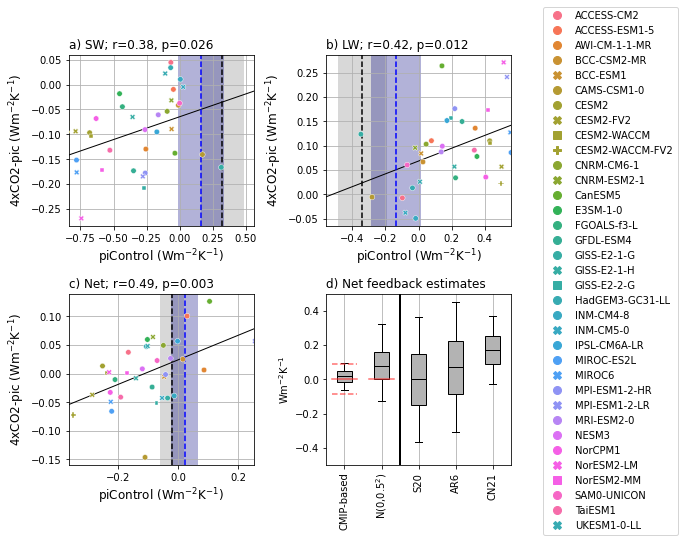

In [5]:
feedback_unstable_plot(bintype='4x')
plt.savefig(f'./paper_figs/Fig3.png',dpi=300,bbox_inches='tight',pad_inches=.1)

In [27]:

def feedback_stable_plot(bintype='4x'):
    '''
    bintype should be 4x or pi
    '''

    inst = retrieve_institution(modelnames)[0].values
    variant = retrieve_institution(modelnames)[1].values
    cols = sns.color_palette("husl", len(np.unique(inst)))
    
    inst2 = pd.Series(inst).replace({i:ii for ii,i in enumerate(pd.unique(inst))})
    
    ms = np.zeros(np.shape(inst))
    for i in np.unique(inst):
        ms[inst==i] = range((inst==i).sum())
    
    hue = np.array(cols)[inst2.values]    
    markers = np.array(['o','X','s','P'])[ms.astype(int)]

    handles2 = [mlines.Line2D([], [], color=c, marker=m, linestyle='None',markersize=8, label=mn)
        for c,m,mn in zip(hue,markers,modelnames)]

    loadadd='pic' if bintype=='pi' else '4x'
    ys,ys2,ys3=np.load('./output/cmip_pi_feeds_binnedpi_2lims_5585_mask_compare_Tfull.npy')
    ys_4x,ys2_4x,ys3_4x=np.load('./output/cmip_4xco2_feeds_binned{0}_2lims_5585_mask_compare_Tfull.npy'.format(loadadd))
    ys_0,ys2_0,ys3_0,ys_ncep,ys2_ncep,ys3_ncep=feedback_calc_B_obs(Tfull=True)

    fig, axs_full = plt.subplots(ncols=3,nrows=2,figsize=[12,6.5])
    for axs,i in zip(axs_full,range(2)):

        const = .21 if i==0 else .11
        sns.scatterplot(x=const*np.array(ys)[:,0,i],y=const*np.array(ys_4x)[:,0,i],ax=axs[0],s=30,c=hue,style=markers,zorder=4,legend='full')
        sns.scatterplot(x=const*np.array(ys2)[:,0,i],y=const*np.array(ys2_4x)[:,0,i],ax=axs[1],s=30,c=hue,style=markers,zorder=4,legend='full')
        sns.scatterplot(x=const*np.array(ys3)[:,0,i],y=const*np.array(ys3_4x)[:,0,i],ax=axs[2],s=30,c=hue,style=markers,zorder=4,legend='full')

        axs_xlim = [ax.get_xlim() for ax in axs]
        axs_ylim = [ax.get_ylim() for ax in axs]
        
        sns.regplot(x=const*np.array(ys)[:,0,i],y=const*np.array(ys_4x)[:,0,i],ax=axs[0],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})
        sns.regplot(x=const*np.array(ys2)[:,0,i],y=const*np.array(ys2_4x)[:,0,i],ax=axs[1],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})    
        sns.regplot(x=const*np.array(ys3)[:,0,i],y=const*np.array(ys3_4x)[:,0,i],ax=axs[2],scatter=False,ci=None,truncate=False,color='k',line_kws={'linewidth':1})

        for ax in axs:
            handles,labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()

        toplot = const*np.array([np.array(ys)[:,0,i],np.array(ys2)[:,0,i],np.array(ys3)[:,0,i]])
        toplot_4x = const*np.array([np.array(ys_4x)[:,0,i],np.array(ys2_4x)[:,0,i],np.array(ys3_4x)[:,0,i]])

        [ax.set_title(t+'; r={0:.02f}, p={1:.03f}'.format(pearsonr(toplot[j],toplot_4x[j])[0],pearsonr(toplot[j],toplot_4x[j])[1]),loc='left') 
            for j,ax,t in zip(range(3),axs,['a)','b)','c)','d)','e)','f)'][i*3:(i*3+3)])]
        [ax.grid() for ax in axs]

        e5_y = const*np.array([np.array(ys_0)[0,i],np.array(ys2_0)[0,i],np.array(ys3_0)[0,i]])
        [ax.axvline(y,linestyle='dashed',color='k') for ax,y in zip(axs,e5_y)]
        e5_ci = const*np.array([np.array(ys_0)[1,i],np.array(ys2_0)[1,i],np.array(ys3_0)[1,i]])
        ncep_y = const*np.array([np.array(ys_ncep)[0,i],np.array(ys2_ncep)[0,i],np.array(ys3_ncep)[0,i]])
        [ax.axvline(y,linestyle='dashed',color='b') for ax,y in zip(axs,ncep_y)]
        ncep_ci = const*np.array([np.array(ys_ncep)[1,i],np.array(ys2_ncep)[1,i],np.array(ys3_ncep)[1,i]])

        for ax,a,b,c,d in zip(axs,e5_y,e5_ci,ncep_y,ncep_ci):
            rect=Polygon([[a-b,-10],[a-b,10],[a+b,10],[a+b,-10]],fc='0.5',alpha=0.3,ec=None)
            rect2=Polygon([[c-d,-10],[c-d,10],[c+d,10],[c+d,-10]],fc=(0,0,0.5),alpha=0.3,ec=None)
            ax.add_patch(rect)
            ax.add_patch(rect2)

        [ax.set_xlim(xlim) for ax,xlim in zip(axs,axs_xlim)]
        [ax.set_ylim(ylim) for ax,ylim in zip(axs,axs_ylim)]
        if i == 1:
            [ax.set_xlabel(r'piControl (Wm$^{-2}$K$^{-1}$)',fontsize=12) for ax in axs]
        axs[0].set_ylabel(r'4xCO2-pic (Wm$^{-2}$K$^{-1}$)',fontsize=12)

    fig.legend(loc='center right',handles=handles2,fontsize=8)
    plt.tight_layout(rect=[0.05, 0, 0.83, 0.95])

    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    get_extent = lambda ax: ax.get_window_extent(r).transformed(fig.transFigure.inverted())

    bboxes = np.array(list(map(get_bbox, axs_full.flat)), mtrans.Bbox).reshape(axs_full.shape)
    extents = np.array(list(map(get_extent, axs_full.flat)), mtrans.Bbox).reshape(axs_full.shape)

    #Get the minimum and maximum extent, get the coordinate half-way between those
    ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs_full.shape).max(axis=1)
    ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs_full.shape).min(axis=1)
    xmax = np.array(list(map(lambda b: b.x1, bboxes.flat))).reshape(axs_full.shape).max(axis=0)
    xmin = np.array(list(map(lambda b: b.x0, bboxes.flat))).reshape(axs_full.shape).min(axis=0)

    xmids=[0.5*(i.x0+i.x1) for i in extents[0]]
    ymids=[0.5*(i.y0+i.y1) for i in np.array(extents)[:,0]]
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)
    xs = np.c_[xmin[1:], xmax[:-1]].mean(axis=1)
    
    # Draw a horizontal lines at those coordinates
    for y in ys:
        line = plt.Line2D([xmin[0],xmax[-1]],[y,y], transform=fig.transFigure, color="black")
        fig.add_artist(line)
    for x in xs:
        line = plt.Line2D([x,x],[ymin[-1],ymax[0]], transform=fig.transFigure, color="black")
        fig.add_artist(line)

    [plt.text(x,0.975,t,transform=fig.transFigure,ha='center',va='center',fontsize=14,fontweight='bold') for x,t in zip(xmids,['SW cloud feedback','LW cloud feedback','Net feedback'])]
    [plt.text(0.025,y,t,transform=fig.transFigure,ha='center',va='center',fontsize=14,fontweight='bold',rotation='vertical') for y,t in zip(ymids,['Stable','Mid','Unstable'])]


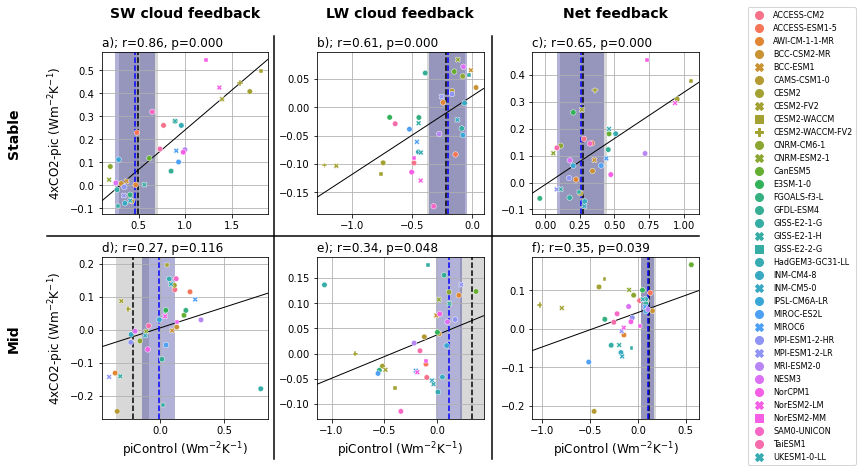

In [28]:
feedback_stable_plot(bintype='4x')
plt.savefig(f'./paper_figs/supp/FigS5.png',dpi=300,bbox_inches='tight',pad_inches=.1)